# 1. Introduction
---
- Traffic Sign Detection is a task that applies algorithms related to Object Detection to detect traffic signs on the road. Traffic Sign Detection models are often widely used in major applications such as Self-driving Cars, Advanced Driver Assistance Systems, and more. A Traffic Sign Detection program typically consists of two stages: locating the position of the traffic sign and recognizing the name of the traffic sign
- In this project, we will build a Traffic Sign Detection program using a Support Vector Machine (SVM) model. The input and output of the program are as follows:

    - **Input**: An image containing a traffic sign
    - **Output**: The coordinates and class names of the traffic signs present in the image

<img src="src/intro.png" style="width: 500px; height: 300px;">

# 2. Project pipeline
---
- The two main modules in this project include:
    - **Module 1**: Building the traffic sign classification model using SVM
    - **Module 2**: Constructing the object detection function using sliding window technique

<img src="src/projpl.png">

*source: AIVN*


# 3. Implement

## 3.1 Preparing

### 3.1.1 Import essential libraries

In [24]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 3.1.2 Download data
---
- The dataset consists of 877 images with 4 classes: 'trafficlight,' 'stop,' 'speedlimit,' and 'crosswalk'.
[Download here!!](https://drive.google.com/file/d/1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b/view)
- There are 2 directories:
    - **images**: The directory containing the images
    - **annotations**: The directory containing the .xml files, which are label files containing information about the coordinates and class of objects in the images corresponding to the file names in the **images** directory

### 3.1.3 Read dataset

In [25]:
annotations_dir = 'traffic_sign_detection/annotations'
img_dir = 'traffic_sign_detection/images'

img_lst = []
label_lst = []

In [26]:
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir,xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir,img_filename)
    img = cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        # ignore traffic light
        if classname == 'trafficlight':
            continue
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        object_img = img[ymin:ymax, xmin:xmax]
        img_lst.append(object_img)
        label_lst.append(classname)

In [27]:
print('Number of objects: ',len(img_lst))
print('Class names: ',list(set(label_lst)))

Number of objects:  1074
Class names:  ['speedlimit', 'stop', 'crosswalk']


## 3.2 Module 1: Traffic Sign Classification

### 3.2.1 Build image preprocessing function using HOG (Histogram of Oriented Gradients)
<img src="src/hog.png">

*source:* [scikit-image.org](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html)

In [28]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)

    resized_img = resize(img, output_shape=(32,32), anti_aliasing=True)

    hog_feature = feature.hog(resized_img,
                              orientations=9,
                              pixels_per_cell=(8,8),
                              cells_per_block=(2,2),
                              transform_sqrt=True,
                              block_norm='L2',
                              feature_vector=True)
    return hog_feature

In [29]:
# With the preprocess_img() function, we proceed to preprocess the entire input images.
img_features_lst = []
for img in img_lst:
    hog_feature = preprocess_img(img)
    img_features_lst.append(hog_feature)
img_features = np.array(img_features_lst)

In [30]:
print('Shape of the first image before preprocessing: ', img_lst[0].shape)
print('Shape of the first image after preprocessing: ', img_features[0].shape)

Shape of the first image before preprocessing:  (321, 328, 3)
Shape of the first image after preprocessing:  (324,)


### 3.2.2 Encode label
---
Currently, the labels are in string format, and we need to convert them into numerical format
to align with the model training requirements. Here, we use LabelEncoder() to transform class
names into corresponding numbers 0, 1, 2...

In [31]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

### 3.2.3 Train test split

In [32]:
random_state = 0
test_size = 0.3
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(img_features,
                                                  encoded_labels,
                                                  test_size=test_size,
                                                  random_state=random_state,
                                                  shuffle=is_shuffle)

### 3.2.4 Normalize data

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### 3.2.5 Train the model

In [34]:
clf = SVC(kernel='rbf',
          random_state=random_state,
          probability=True,
          C=0.5)
clf.fit(X_train,y_train)

SVC(C=0.5, probability=True, random_state=0)

### 3.2.6 Evaluate the model

In [35]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred,y_val)

print('Evaluation results on val set')
print('Accuracy: ', score)

Evaluation results on val set
Accuracy:  0.9721362229102167


## 3.3 Module 2: Traffic Sign Localization
---
For the Object Detection task, the most challenging aspect is accurately determining the coordinates
of the object to be detected. In this project, we will apply a basic object search technique called
the **Sliding Window technique**. The main idea of this algorithm is as follows
- **Step 1:** Define a window frame with dimensions (w, h). The window frame size must be chosen to be appropriate for the object's size
- **Step 2:** Slide this window over each pixel of the input image, sequentially from left to right and from top to bottom
- **Step 3:** For each sliding step, we pass the image frame captured within the window frame to the traffic sign classification model to determine whether this window frame contains a traffic sign or not

However, **the sliding window technique has several limitations**, one of which is its difficulty in detecting small-sized
objects. To partially address this issue, we can apply the **Pyramid Image technique**. Essentially, this technique generates
a series of images with gradually decreasing sizes. As a result, small objects in the original image become larger when
viewed in the smaller images. Then, we apply the sliding window method to this series of images in the hope of detecting
small objects present in the original image.


### 3.3.1 Pyramid function

In [36]:
def pyramid(img, scale=0.8, min_size=(30,30)):
    acc_scale = 1.0
    pyramid_imgs = [(img,acc_scale)]
    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img, (w,h))
        pyramid_imgs.append((img, acc_scale))
    return pyramid_imgs

### 3.3.2 Sliding window functiom

In [37]:
def sliding_window(img, window_sizes, stride):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append([xmin, ymin, xmax, ymax])
    return windows

### 3.3.3 Function for visualizing bounding boxes

In [38]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box
        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (0,255,0), 2)
        classname =  label_encoder.inverse_transform([predict_id])[0]
        label = f'{classname} {conf_score:.2f}'
        (w,h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0,255,0), -1)
        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)

        plt.imshow(img)
        plt.axis('off')
        plt.show()

### 3.3.4 Non-Maximum Suppression (NMS)
The NMS (Non-Maximum Suppression) technique is used to eliminate overlapping bounding boxes and
retain only the bounding box with the highest confidence score. To build an NMS function, first,
we implement a function to calculate **IoU (Intersection over Union)**. IoU is the intersection ratio
between two bounding boxes, calculated using the following formula:

<img src="src/iou.png" style="width: 200px; height: 200px;">

In [39]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:,0])
    yymin = np.maximum(bbox[1], bboxes[:,1])
    xxmax = np.minimum(bbox[2], bboxes[:,2])
    yymax = np.minimum(bbox[3], bboxes[:,3])
    w = np.maximum(0,xxmax-xxmin+1)
    h = np.maximum(0, yymax-yymin+1)
    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)
    return iou

In [40]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []
    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)
        iou = compute_iou([xmin[i],ymin[i],xmax[i],ymax[i]],
                          np.array([
                              xmin[sorted_indices[1:]],
                              ymin[sorted_indices[1:]],
                              xmax[sorted_indices[1:]],
                              ymax[sorted_indices[1:]]
                          ]).T,
                          areas[i],
                          areas[sorted_indices[1:]])
        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep+1]
    return [bboxes[i] for i in keep]

# 4. Testing

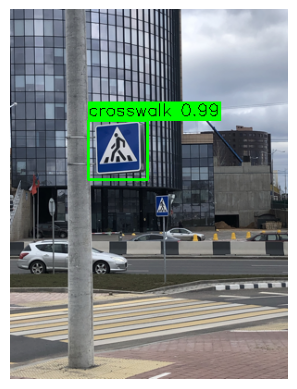

traffic_sign_detection/images\road189.png
Time process: 3.1919891834259033


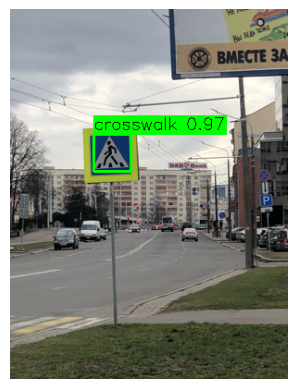

traffic_sign_detection/images\road190.png
Time process: 3.2289278507232666


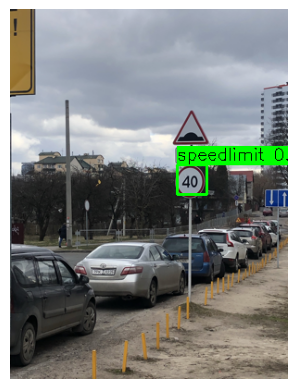

traffic_sign_detection/images\road191.png
Time process: 3.0192980766296387


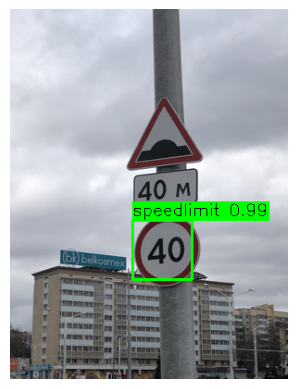

traffic_sign_detection/images\road192.png
Time process: 3.2053799629211426


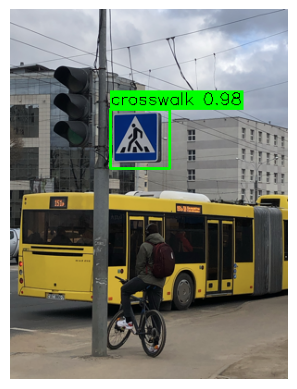

traffic_sign_detection/images\road193.png
Time process: 3.113180160522461


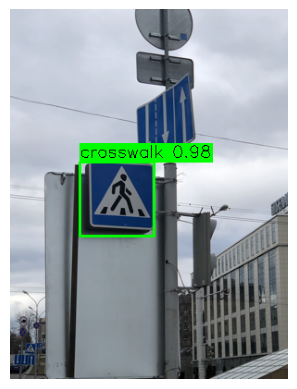

traffic_sign_detection/images\road194.png
Time process: 3.0480525493621826


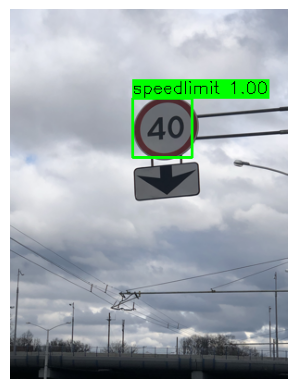

traffic_sign_detection/images\road196.png
Time process: 2.9560928344726562


In [41]:
img_dir = 'traffic_sign_detection/images'
img_filename_lst = os.listdir(img_dir)[100:110]
conf_threshold = 0.95
stride = 12
window_sizes = [(32,32),(64,64),(128,128)]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir,img_filename)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(pyramid_img, window_sizes=window_sizes, stride=stride)

        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]

            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymin = int(ymin / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score])
    bboxes = nms(bboxes,0.1)
    if bboxes:
        visualize_bbox(img, bboxes=bboxes, label_encoder=label_encoder)
        print(img_filepath)
        print(f'Time process: {time.time() - start_time}')